## Zillow Top Tier Housing Data


In this project we will look at the top tier home values across all 50 states. 

We will be using Zillow's ZHVI Home Value Index. It is a measure of typical home value and market changes across a given region and housing type. It reflects the value for homes in the 35th to 65th percentile range.

Zillow publishes top-tier ZHVI ($, typical value for homes within the 65th to 95th percentile range for a given region) and bottom-tier ZHVI.

A user guide for this data can be found at: [Zillow](https://www.zillow.com/research/zhvi-user-guide/). 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import csv 
import numpy as np 
import warnings 
from pandasql import sqldf
# Ignore all warnings 
warnings.filterwarnings('ignore')


# Load your data into a DataFrame (assuming it's in a CSV file)

csv_file = r"C:\Users\Wolfrank\Desktop\Zillow.csv"
data = pd.read_csv(csv_file)
df = data


### Cleaning the Data 


In [3]:

# Next we clean up the data in the dataframe we just created, then we save the new file.

# Data Cleaning:  Drop Columns 
columns_to_remove = ['RegionID', 'RegionType', 'StateName',]
data.drop(columns=columns_to_remove, inplace=True)

# Rename Column from RegionName to State
df.rename(columns={'RegionName': 'State'}, inplace=True)

# Add 1 to Index 
df.index = df.index + 1

# Add 1 to SizeRank 
df['SizeRank'] = df['SizeRank'] + 1

# Show number of columns
num_columns = len(data.columns)
print("Number of columns:", num_columns)

display(df)

Number of columns: 51


,SizeRank,State,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,...,10/31/2022,11/30/2022,12/31/2022,1/31/2023,2/28/2023,3/31/2023,4/30/2023,5/31/2023,6/30/2023,7/31/2023
1,1,California,"1,010,157.03","1,012,997.20","1,017,687.95","1,022,485.24","1,026,952.62","1,031,142.67","1,034,553.47","1,038,088.60",...,"1,388,930.11","1,376,351.17","1,365,640.69","1,349,536.48","1,331,812.63","1,318,644.67","1,313,776.90","1,316,454.54","1,325,324.18","1,341,108.82"
2,2,Texas,"357,269.45","357,782.32","358,412.61","359,412.86","360,688.93","362,151.96","363,891.37","365,822.27",...,"532,105.51","528,545.81","524,829.49","521,187.45","518,476.90","517,509.82","517,123.74","517,491.48","518,693.11","520,137.03"
3,3,Florida,"418,248.13","418,802.55","419,552.05","420,841.50","422,743.27","425,119.60","427,888.45","430,657.11",...,"671,682.72","670,050.89","667,964.77","664,787.53","661,775.13","661,015.61","661,671.22","663,656.64","666,775.03","670,282.22"
4,4,New York,"690,210.31","693,015.33","693,910.26","693,100.09","693,893.69","695,226.93","698,205.02","699,981.70",...,"844,798.50","840,894.00","835,562.38","830,563.40","826,754.70","826,619.79","828,228.14","831,973.72","837,724.80","844,885.84"
5,5,Pennsylvania,"335,935.47","336,900.44","337,641.14","338,545.74","339,749.56","341,004.42","342,010.48","343,080.18",...,"442,150.02","442,246.20","442,397.14","441,695.92","441,335.83","442,410.63","444,593.91","447,405.56","450,479.79","454,024.12"
6,6,Illinois,"357,412.36","356,471.43","355,391.39","354,901.90","354,797.42","355,092.67","355,916.39","357,078.08",...,"431,662.33","430,503.82","429,329.67","428,739.96","428,391.45","429,022.68","429,375.42","430,677.89","433,281.28","436,567.53"
7,7,Ohio,"272,835.08","273,670.82","274,235.67","275,015.43","276,117.20","277,291.76","278,632.96","279,996.30",...,"371,393.22","371,248.72","371,095.11","371,301.90","371,832.66","373,447.41","375,182.41","377,375.30","379,453.14","381,272.81"
8,8,Georgia,"357,878.82","358,461.71","359,081.64","360,062.20","361,342.18","363,000.74","364,967.97","367,159.45",...,"524,631.21","522,735.07","520,415.83","518,330.42","516,799.91","517,033.03","517,620.21","519,478.18","522,161.75","525,356.70"
9,9,North Carolina,"355,739.44","356,297.63","356,922.47","358,036.28","359,549.58","361,386.43","363,186.53","365,085.51",...,"540,551.45","538,276.84","535,798.16","533,270.51","531,354.74","531,537.40","532,334.40","534,778.51","538,365.26","542,623.91"
10,10,Michigan,"299,772.62","299,910.94","299,882.68","300,244.12","301,048.21","301,914.79","303,047.67","304,480.98",...,"397,356.16","395,913.24","394,584.94","394,051.71","394,175.00","395,806.96","397,219.51","399,235.77","401,152.93","402,754.27"


In [4]:
# Get the column names and join them with a comma
column_names = ','.join(df.columns)

print(column_names)


SizeRank,State,7/31/2019,8/31/2019,9/30/2019,10/31/2019,11/30/2019,12/31/2019,1/31/2020,2/29/2020,3/31/2020,4/30/2020,5/31/2020,6/30/2020,7/31/2020,8/31/2020,9/30/2020,10/31/2020,11/30/2020,12/31/2020,1/31/2021,2/28/2021,3/31/2021,4/30/2021,5/31/2021,6/30/2021,7/31/2021,8/31/2021,9/30/2021,10/31/2021,11/30/2021,12/31/2021,1/31/2022,2/28/2022,3/31/2022,4/30/2022,5/31/2022,6/30/2022,7/31/2022,8/31/2022,9/30/2022,10/31/2022,11/30/2022,12/31/2022,1/31/2023,2/28/2023,3/31/2023,4/30/2023,5/31/2023,6/30/2023,7/31/2023


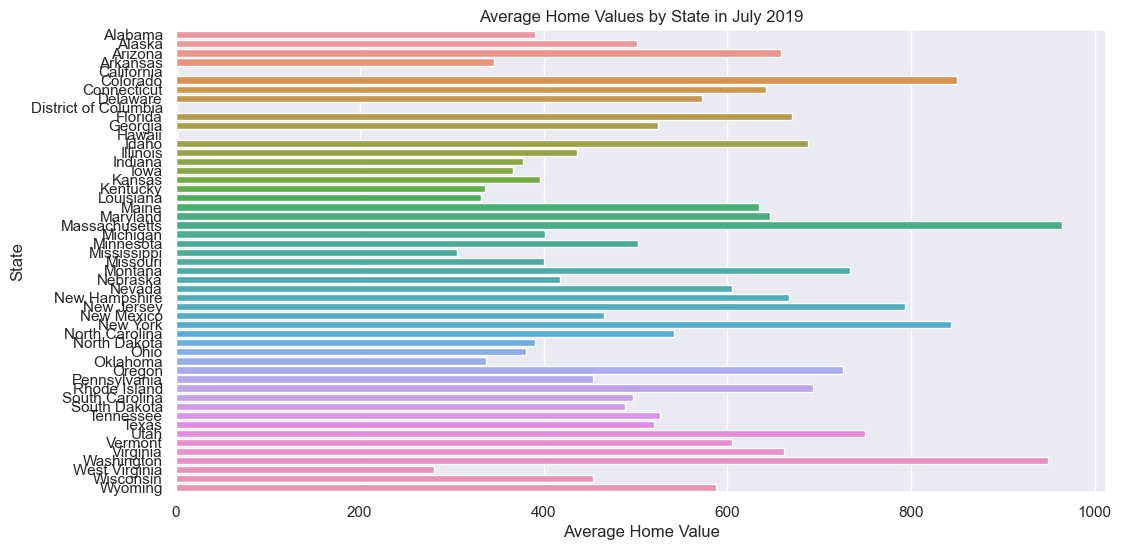

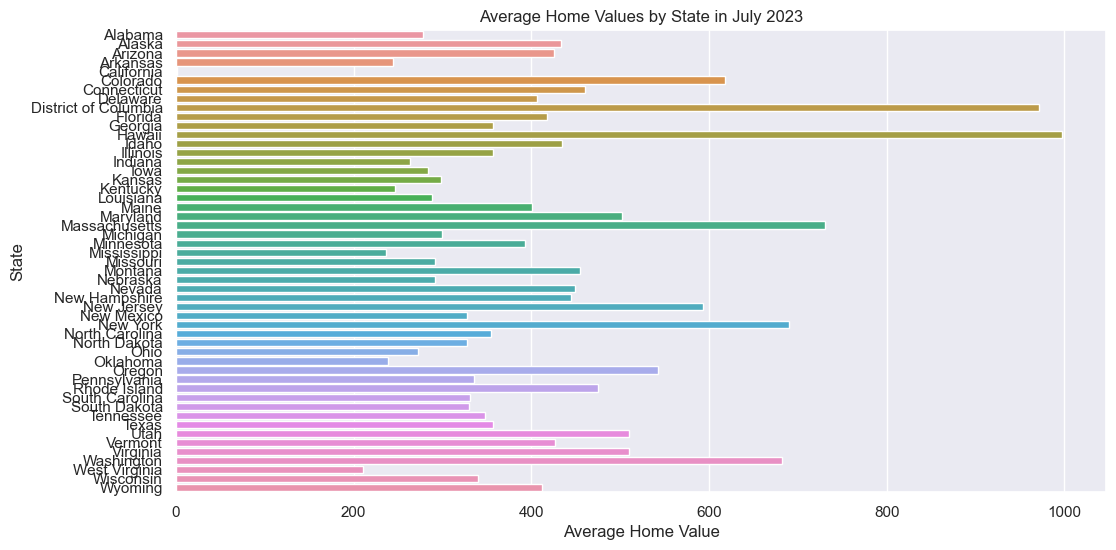

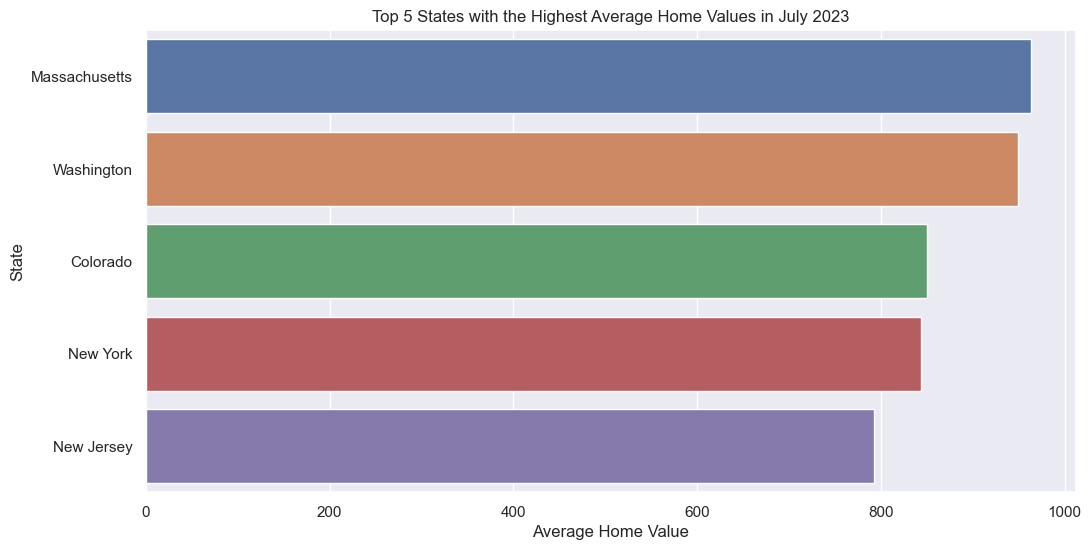

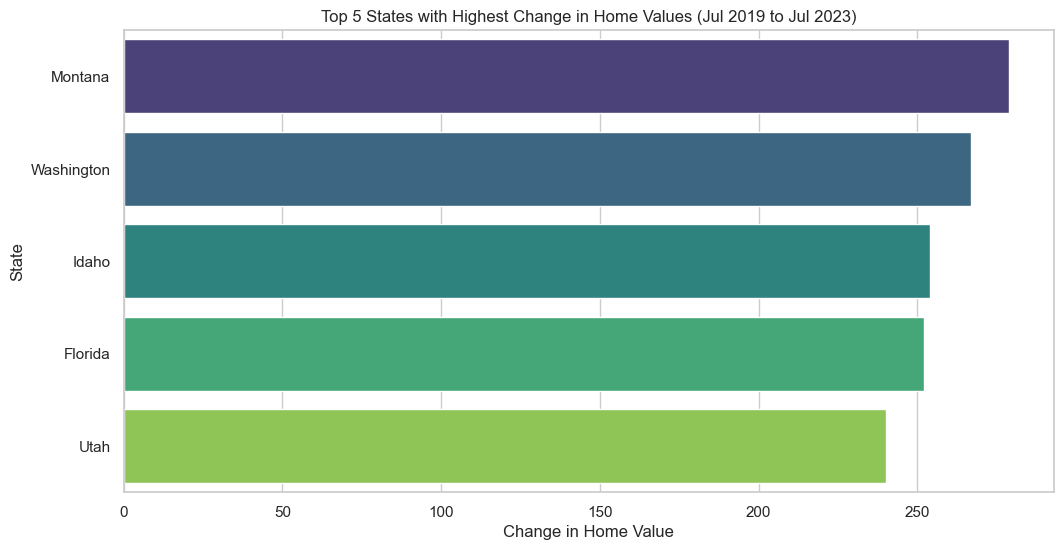

In [5]:
# Load the CSV data into a SQLite database
con = sqlite3.connect('zillow_data.db')

df.to_sql('zillow_data', con, if_exists='replace', index=False)

# Define SQL queries for analysis
query1 = """
SELECT State, AVG("7/31/2019") AS AvgHomeValue
FROM zillow_data
GROUP BY State
"""

query2 =  """
SELECT State, AVG("7/31/2023") AS AvgHomeValue
FROM zillow_data
GROUP BY State
"""

query3 = """
SELECT State, AVG("7/31/2023") AS AvgHomeValue
FROM zillow_data
GROUP BY State
ORDER BY AvgHomeValue DESC
LIMIT 5
"""

query4 = """
SELECT State, ("7/31/2023" - "7/31/2019") AS ChangeInValue
FROM zillow_data
ORDER BY ChangeInValue DESC
LIMIT 5
"""


# Execute queries and fetch results
query_results = []

for query in [query1, query2, query3, query4]:
    result = pd.read_sql_query(query, con)
    query_results.append(result)

# Create Seaborn charts
sns.set(style="darkgrid")

# Chart 1: Average home values by state in September 2021
plt.figure(figsize=(12, 6))
sns.barplot(data=query_results[1], x='AvgHomeValue', y='State')
plt.title('Average Home Values by State in July 2019')
plt.xlabel('Average Home Value')
plt.ylabel('State')

# Chart 2: Average home values by state in September 2021
plt.figure(figsize=(12, 6))
sns.barplot(data=query_results[0], x='AvgHomeValue', y='State')
plt.title('Average Home Values by State in July 2023')
plt.xlabel('Average Home Value')
plt.ylabel('State')

# Chart 3: Top 5 states with the highest average home values in May 2023
plt.figure(figsize=(12, 6))
sns.barplot(data=query_results[2], x='AvgHomeValue', y='State')
plt.title('Top 5 States with the Highest Average Home Values in July 2023')
plt.xlabel('Average Home Value')
plt.ylabel('State')

#Chart 4:  Execute the query and fetch results
result4 = pd.read_sql_query(query4, con)
# Create Seaborn histogram chart
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(data=result4, x='ChangeInValue', y='State', palette='viridis')
plt.title('Top 5 States with Highest Change in Home Values (Jul 2019 to Jul 2023)')
plt.xlabel('Change in Home Value')
plt.ylabel('State')



# Show the charts
plt.show()

# Close the database connection
con.close()

